In [1]:
### Dogs vs Cats, not cleaned yet

In [5]:
import torch
from torch import nn
import torchvision
import torch.nn.functional as F
from torchvision import transforms, models, datasets
from PIL import Image
from torch import optim

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Currently operating on {device}')
import cv2, glob, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
from torchsummary import summary


Currently operating on cuda


In [4]:
# If operating in Colab, uncomment and run the cell for extraction of data.
#!pip install -q kaggle
#from google.colab import files
#files.upload() #Use your Kaggle Token API from the downloads

#!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!ls ~/.kaggle
#!chmod 600 /root/.kaggle/kaggle.json

#!kaggle datasets download -d tongpython/cat-and-dog

#!unzip cat-and-dog.zip

Saving kaggle.json to kaggle.json
kaggle.json
 98% 214M/218M [00:02<00:00, 103MB/s] 
100% 218M/218M [00:02<00:00, 110MB/s]


In [19]:
import os
os.path.exists('C:/Users/tommy/git/Cats-vs-Dogs-PyTorch/archive(1)/training_set/training_set/') #Check for the path

True

In [37]:
train_data_dir = 'C:/Users/tommy/git/Cats-vs-Dogs-PyTorch/archive(1)/training_set/training_set/'
test_data_dir = 'C:/Users/tommy/git/Cats-vs-Dogs-PyTorch/archive(1)/test_set/test_set/'

In [38]:
from torch.utils.data import DataLoader, Dataset
from random import shuffle, seed 
seed(10)
class cats_dogs(Dataset):
    def __init__(self, folder):
        cats = glob(folder+'/cats/*.jpg')
        dogs = glob(folder+'/dogs/*.jpg')
        self.fpaths = cats + dogs
        shuffle(self.fpaths)
        self.targets = [fpath.split('/')[-1].startswith('dog') for fpath in self.fpaths]
    def __len__(self):
        return len(self.fpaths)
    def __getitem__ (self, ix):
        f = self.fpaths[ix]
        target = self.targets[ix]
        im = (cv2.imread(f)[:,:,::-1])
        im = cv2.resize(im, (224,224))
        return torch.tensor(im/255).permute(2,0,1).to(device).float(), torch.tensor([target]).float().to(device)

    

In [39]:
data = cats_dogs(train_data_dir)

tensor([1.], device='cuda:0')


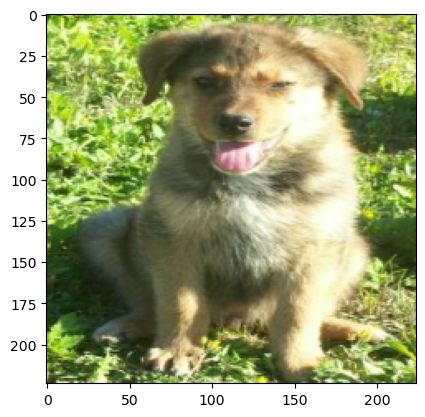

In [40]:
im, label = data[200]
plt.imshow(im.permute(1,2,0).cpu())
print(label)

In [41]:
def conv_layer(ni,no, kernel_size, stride=1):
    return nn.Sequential(
        nn.Conv2d(ni,no, kernel_size, stride),
        nn.ReLU(),
        nn.BatchNorm2d(no),
        nn.MaxPool2d(2))
  
def get_model():
    model = nn.Sequential(
        conv_layer(3,64,3),
        conv_layer(64,512,3),
        conv_layer(512,512,3),
        conv_layer(512,512,3),
        conv_layer(512,512,3),
        conv_layer(512,512,3),
        nn.Flatten(),
        nn.Linear(512,1),
        nn.Sigmoid(),
        ).to(device)
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

In [42]:
model, loss_fn, optimizer = get_model()
summary(model, input_size=(3,224,224))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─BatchNorm2d: 2-3                  128
|    └─MaxPool2d: 2-4                    --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-5                       295,424
|    └─ReLU: 2-6                         --
|    └─BatchNorm2d: 2-7                  1,024
|    └─MaxPool2d: 2-8                    --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-9                       2,359,808
|    └─ReLU: 2-10                        --
|    └─BatchNorm2d: 2-11                 1,024
|    └─MaxPool2d: 2-12                   --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-13                      2,359,808
|    └─ReLU: 2-14                        --
|    └─BatchNorm2d: 2-15                 1,024
|    └─MaxPool2d: 2-16                   --
├─Sequential: 1-5                      

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─BatchNorm2d: 2-3                  128
|    └─MaxPool2d: 2-4                    --
├─Sequential: 1-2                        --
|    └─Conv2d: 2-5                       295,424
|    └─ReLU: 2-6                         --
|    └─BatchNorm2d: 2-7                  1,024
|    └─MaxPool2d: 2-8                    --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-9                       2,359,808
|    └─ReLU: 2-10                        --
|    └─BatchNorm2d: 2-11                 1,024
|    └─MaxPool2d: 2-12                   --
├─Sequential: 1-4                        --
|    └─Conv2d: 2-13                      2,359,808
|    └─ReLU: 2-14                        --
|    └─BatchNorm2d: 2-15                 1,024
|    └─MaxPool2d: 2-16                   --
├─Sequential: 1-5                      

In [43]:
def get_data():
    
    train = cats_dogs(train_data_dir)
    trn_dl = DataLoader(train, batch_size=32, shuffle=True, drop_last=True)

    val = cats_dogs(test_data_dir)
    val_dl = DataLoader(val, batch_size=32, shuffle=True, drop_last = True)

    return trn_dl, val_dl

def train_batch(x,y,model,opt,loss_fn):
    model.train()
    prediction = model(x)
    batch_loss = loss_fn(prediction, y)
    batch_loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item()

@torch.no_grad()
def accuracy(x,y,model):
    prediction = model(x)
    is_correct = (prediction>0.5) == y
    return is_correct.cpu().numpy().tolist()
@torch.no_grad()
def val_loss(x,y,model):
    prediction = model(x)
    val_loss = loss_fn(prediction, y)
    return val_loss.item()

In [44]:
trn_dl, val_dl = get_data()
model, loss_fn, optimizer = get_model()

In [45]:
train_losses, train_accuracies = [],[]
val_losses, val_accuracies = [],[]

for epoch in range(10):
    print(f'Completing Epoch: {epoch}')
    train_epoch_losses, train_epoch_accuracies = [],[]
    val_epoch_accuracies = []
    

    for ix, batch in enumerate(iter(trn_dl)):
        
        x,y = batch
        batch_loss = train_batch(x,y,model, optimizer, loss_fn)
        train_epoch_losses.append(batch_loss)
        train_epoch_loss = np.array(train_epoch_losses).mean()
  
    for ix, batch in enumerate(iter(trn_dl)):
        x,y = batch
        is_correct = accuracy(x,y,model)
        train_epoch_accuracies.extend(is_correct)
        train_epoch_accuracy = np.mean(train_epoch_accuracies)

    for ix, batch in enumerate(iter(val_dl)):
        x,y = batch
        val_is_correct = accuracy(x,y,model)
        val_epoch_accuracies.extend(val_is_correct)
        val_epoch_accuracy = np.mean(val_epoch_accuracies)

    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_accuracies.append(val_epoch_accuracy)

Completing Epoch: 0
Completing Epoch: 1
Completing Epoch: 2
Completing Epoch: 3
Completing Epoch: 4
Completing Epoch: 5
Completing Epoch: 6
Completing Epoch: 7
Completing Epoch: 8
Completing Epoch: 9


C:\Users\tommy\AppData\Local\Temp\ipykernel_38144\470311717.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])


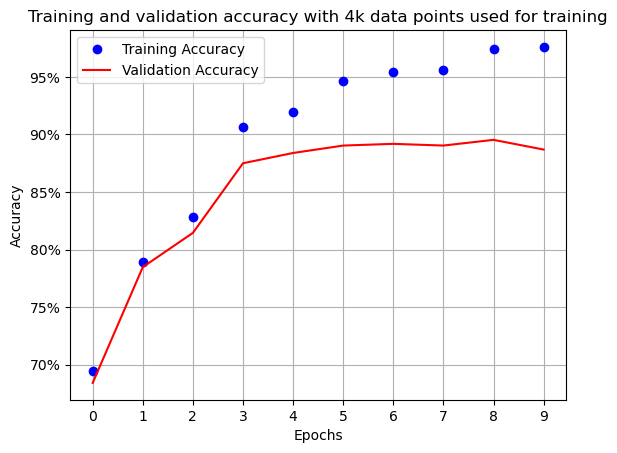

In [46]:
epochs = np.arange(10)
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
plt.plot(epochs, train_accuracies, 'bo', label = 'Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', label = 'Validation Accuracy')
plt.gca().xaxis.set_major_locator(mtick.MultipleLocator(1))
plt.title('Training and validation accuracy with 4k data points used for training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.gca().set_yticklabels(['{:.0f}%'.format(x*100) for x in plt.gca().get_yticks()])
plt.legend()
plt.grid('off')
plt.show()

In [47]:
torch.save(model.state_dict(), 'C:/Users/tommy/git/Cats-vs-Dogs-PyTorch/Cats_Dogs_Trained.pth')

In [ ]:
model = TheModelClass(*args, **kwargs)
model.load_state_dict(torch.load(PATH))
model.eval()

In [50]:
def predict_custom_img(PATH):
    img = cv2.imread(PATH)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img1 = cv2.resize(img, (224,224))
    img1 = torch.tensor(img1/255).permute(2,0,1).to(device).float()
    img1 = torch.unsqueeze(img1,0)
    img1 = img1.permute(0,1,2,3)
    print(img1.shape)
    prediction = model(img1)
    if prediction < 0.5:
        a = str(f'This is a cat {prediction}')
    else:
        a = str(f'This is a dog {prediction}')
    plt.imshow(img)
    plt.title(a)
    return img1

torch.Size([1, 3, 224, 224])


tensor([[[[0.2706, 0.2784, 0.2980,  ..., 0.3843, 0.5333, 0.5725],
          [0.2314, 0.2784, 0.2784,  ..., 0.3059, 0.4510, 0.5373],
          [0.2157, 0.2353, 0.3451,  ..., 0.2784, 0.3451, 0.4431],
          ...,
          [0.5765, 0.5647, 0.5608,  ..., 0.5333, 0.5451, 0.5451],
          [0.5647, 0.5608, 0.5608,  ..., 0.4980, 0.5412, 0.5412],
          [0.5647, 0.5608, 0.5608,  ..., 0.4863, 0.5137, 0.5255]],

         [[0.2549, 0.2706, 0.2941,  ..., 0.3176, 0.4667, 0.5020],
          [0.2039, 0.2667, 0.2706,  ..., 0.2353, 0.3804, 0.4667],
          [0.1804, 0.2196, 0.3451,  ..., 0.2118, 0.2745, 0.3765],
          ...,
          [0.6588, 0.6471, 0.6431,  ..., 0.6235, 0.6314, 0.6314],
          [0.6510, 0.6471, 0.6431,  ..., 0.5882, 0.6314, 0.6275],
          [0.6510, 0.6471, 0.6431,  ..., 0.5804, 0.6039, 0.6118]],

         [[0.2118, 0.2392, 0.2627,  ..., 0.2627, 0.4078, 0.4549],
          [0.1647, 0.2353, 0.2392,  ..., 0.1843, 0.3216, 0.4157],
          [0.1451, 0.1843, 0.3137,  ..., 0

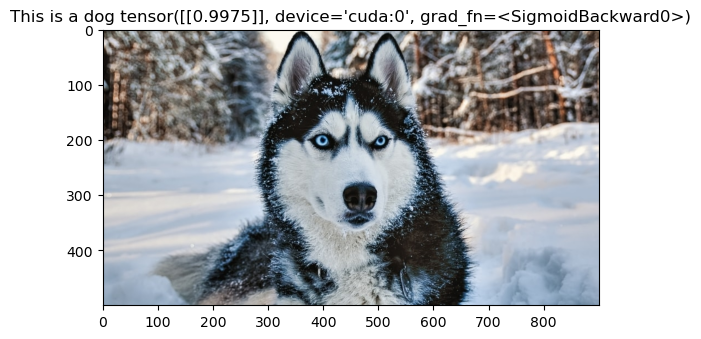

In [51]:
predict_custom_img('C:/Users/tommy/git/Cats-vs-Dogs-PyTorch/Custom Images Pred/husky.jpg')

In [101]:
def predict_custom_img_features(PATH):
    img = cv2.imread(PATH)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img1 = cv2.resize(img, (224,224))
    img1 = torch.tensor(img1/255).permute(2,0,1).to(device).float()
    img1 = torch.squeeze(img1,0)
    print(f'The tensor shape is {img1.shape)
    return img1

In [108]:
im = predict_custom_img_features('/content/puppy.jpg')
first_layer = nn.Sequential(*list(model.children())[:1])
intermediate_output = first_layer(im[None])[0].detach()

torch.Size([3, 224, 224])


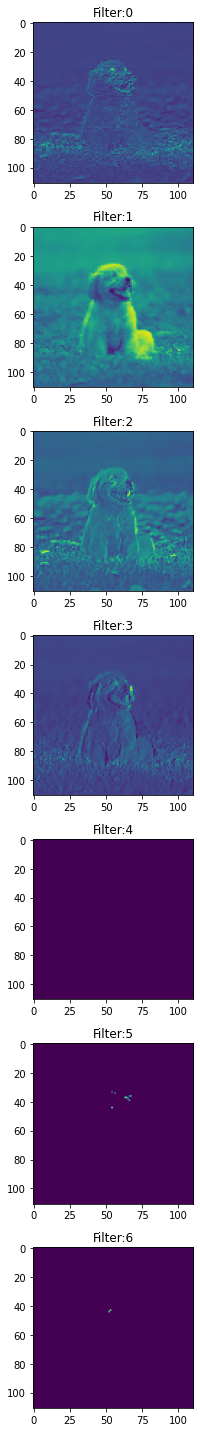

In [109]:
fig, ax = plt.subplots(7,1, figsize = (20,20))
for ix, axis in enumerate(ax.flat):
  axis.set_title('Filter:'+str(ix))
  axis.imshow(intermediate_output[ix].cpu())
plt.tight_layout()
plt.show()

torch.Size([3, 224, 224])


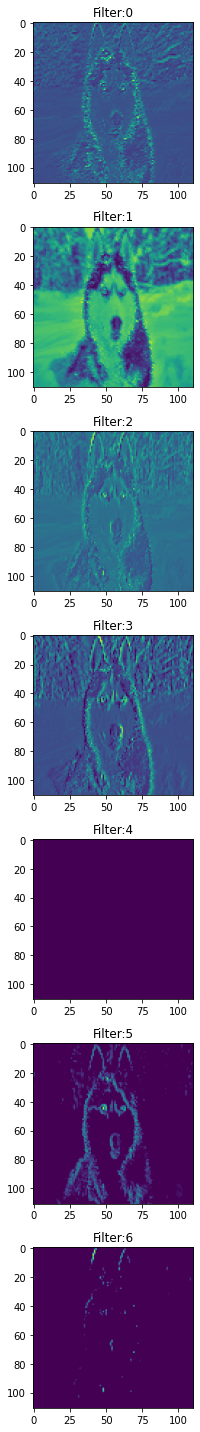

In [118]:
im = predict_custom_img_features('/content/husky.jpg')
first_layer = nn.Sequential(*list(model.children())[:1])
intermediate_output = first_layer(im[None])[0].detach()

fig, ax = plt.subplots(7,1, figsize = (20,20))
for ix, axis in enumerate(ax.flat):
  axis.set_title('Filter:'+str(ix))
  axis.imshow(intermediate_output[ix].cpu())
plt.tight_layout()
plt.show()

torch.Size([3, 224, 224])


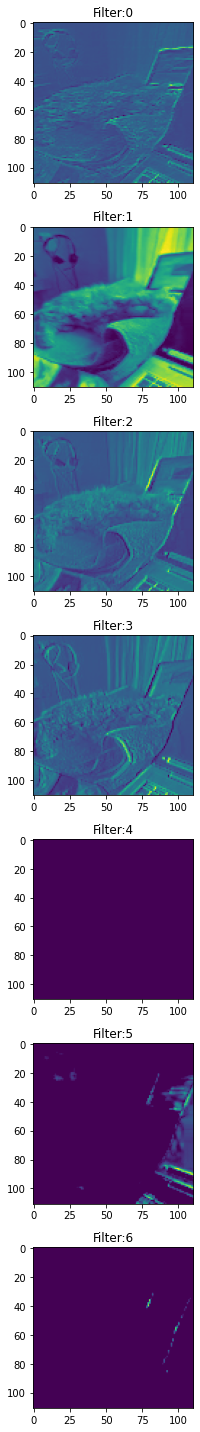

In [114]:
#Cat
im = predict_custom_img_features('/content/phoebe.jpg')
first_layer = nn.Sequential(*list(model.children())[:1])
intermediate_output = first_layer(im[None])[0].detach()
fig, ax = plt.subplots(7,1, figsize = (20,20))
for ix, axis in enumerate(ax.flat):
  axis.set_title('Filter:'+str(ix))
  axis.imshow(intermediate_output[ix].cpu())
  #axis.imshow(cv2.imread('/content/phoebe.jpg'))
plt.tight_layout()
plt.show()